In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [3]:
RUN_LONG = True

In [4]:
data_dir = Path("../data/raw/IMC_Breast_cancer_Danenberg_2022")
objects_path = data_dir / "SingleCells.csv"

if objects_path.with_suffix('.parquet').exists():
    obj = pd.read_parquet(objects_path.with_suffix('.parquet'))
else:
    obj = pd.read_csv(objects_path)
    # for latter use
    obj.to_parquet(objects_path.with_suffix('.parquet'))
obj

,ImageNumber,ObjectNumber,metabric_id,cellPhenotype,is_epithelial,is_tumour,is_normal,is_dcis,is_interface,is_perivascular,...,CD31-vWF,CXCL12,HLA-ABC,panCK,c-Caspase3,DNA1,DNA2,Location_Center_X,Location_Center_Y,AreaShape_Area
0,1,1,MB-0282,CK^{med}ER^{lo},1,1,0,0,1,0,...,0.495330,0.401104,9.282180,18.180412,0.163026,29.445302,54.989698,121.418605,4.023256,43
1,1,2,MB-0282,ER^{hi}CXCL12^{+},1,1,0,0,1,0,...,0.552035,2.567602,1.417755,48.593726,0.310149,23.160734,42.596685,150.468531,6.083916,143
2,1,4,MB-0282,CD4^{+} T cells & APCs,0,1,0,0,0,0,...,0.493669,0.117742,3.791699,3.404438,0.242591,16.884008,31.325295,221.930233,5.139535,129
3,1,5,MB-0282,CK^{med}ER^{lo},1,1,0,0,0,0,...,0.373286,1.048929,2.364418,23.289196,0.297700,8.475436,15.654673,354.136364,5.890909,110
4,1,7,MB-0282,CD4^{+} T cells,0,1,0,0,1,0,...,0.287512,0.058795,4.690886,0.664581,0.078051,14.009167,28.587826,469.174603,7.158730,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123461,797,3818,MB-0406,CK8-18^{hi}CXCL12^{hi},1,1,0,0,0,0,...,0.412993,7.255870,0.947830,76.300971,0.000000,16.235925,31.912625,482.950000,947.825000,40
1123462,797,3819,MB-0406,CK8-18^{hi}CXCL12^{hi},1,1,0,0,0,0,...,0.609522,3.370633,1.534348,53.953806,0.205527,7.448000,12.347708,605.791667,945.333333,24
1123463,797,3820,MB-0406,CK8-18^{hi}CXCL12^{hi},1,1,0,0,1,0,...,0.562381,2.553417,0.629895,41.573201,0.187847,9.222450,18.821950,833.200000,947.350000,20
1123464,797,3822,MB-0406,CK^{lo}ER^{lo},1,1,0,0,1,0,...,0.133439,0.019060,1.156061,0.053584,0.000000,3.641944,7.286806,851.916667,949.222222,36


In [5]:
obj.rename(columns={'Location_Center_X': 'x', 'Location_Center_Y': 'y'}, inplace=True)
sample_col = 'ImageNumber'  # != from `sample_cols`
patient_col = 'metabric_id'
pheno_col = 'cellPhenotype'
sample_cols = [sample_col, patient_col, pheno_col, 'ObjectNumber']
# this file contains 'c-Caspase3c-PARP' instead of 'c-Caspase3c' as in the dataframe
# all_epitopes = pd.read_csv(data_dir / 'markerStackOrder.csv').iloc[:, 1].values
# so instead we directly do:
all_epitopes = obj.columns[11:50].values
# remove Histone H3 and DNA markers
marker_cols = list(all_epitopes[1:-2])
pos_cols = ['x', 'y']
cell_type_cols = [
    'is_epithelial',
    'is_tumour',
    'is_normal',
    'is_dcis',
    'is_interface',
    'is_perivascular',
    'is_hotAggregate',
    ]
nb_phenotypes = obj[pheno_col].unique().size
all_cols = sample_cols + marker_cols + pos_cols + cell_type_cols + [pheno_col]
# columns we want to include in network data
net_cols = pos_cols + [pheno_col] + cell_type_cols + marker_cols

print(f'nb phenotypes: {nb_phenotypes}')
print(f'nb used markers: {len(marker_cols)}')

nb phenotypes: 32
nb used markers: 36


In [6]:
# Show number of cells per sample
sample_sizes = obj[['ImageNumber', 'ObjectNumber']].groupby(['ImageNumber']).count()
sample_sizes

,ObjectNumber
ImageNumber,
1,1624
2,1057
3,1648
4,1348
5,2018
...,...
793,372
794,4460
795,2689


In [7]:
# aggregate unique pairs of patients and image IDs
sample_patient_counts = obj[sample_cols].groupby([sample_col, patient_col]).count()
print(sample_patient_counts)

# count occurrences of patient IDs in patient / image pairs
occ = sample_patient_counts.index.get_level_values(1).value_counts()
print(occ)

n_patient_multiple = np.sum(occ.values != 1)
print(f'There are {n_patient_multiple} patients with multiple samples')

sample_patient_mapper = dict(sample_patient_counts.index.values)

                         cellPhenotype  ObjectNumber
ImageNumber metabric_id                             
1           MB-0282               1624          1624
2           MB-0099               1057          1057
3           MB-0598               1648          1648
4           MB-0606               1348          1348
5           MB-0190               2018          2018
...                                ...           ...
793         MB-0359                372           372
794         MB-0353               4460          4460
795         MB-0158               2689          2689
796         MB-0158                737           737
797         MB-0406               3758          3758

[794 rows x 2 columns]
MB-0359    4
MB-0135    3
MB-0175    3
MB-0145    3
MB-0184    3
          ..
MB-0180    1
MB-0181    1
MB-0182    1
MB-0183    1
MB-0129    1
Name: metabric_id, Length: 718, dtype: int64
There are 59 patients with multiple samples


In [8]:
survival_path = data_dir / "IMCClinical.csv"
surv = pd.read_csv(survival_path, index_col=0)
surv

,ERStatus,LymphNodesOrdinal,sizeOrdinal,Grade,ERBB2_pos,yearsToStatus,DeathBreast,isValidation,PAM50,IntClust
metabric_id,,,,,,,,,,
MB-0000,pos,7+,20-50mm,3.0,False,11.540041,0,False,Normal-like,IntClust 4+
MB-0002,pos,0,5-10mm,3.0,False,6.951403,0,False,Luminal A,IntClust 4+
MB-0005,pos,1,10-20mm,2.0,False,13.445585,1,False,Luminal B,IntClust 3
MB-0006,pos,2-3,20-50mm,2.0,False,13.546886,0,False,Luminal B,IntClust 9
MB-0008,pos,7+,20-50mm,3.0,False,3.397673,1,False,Luminal B,IntClust 9
...,...,...,...,...,...,...,...,...,...,...
MB-3824,pos,0,20-50mm,3.0,False,10.387406,1,True,Luminal B,IntClust 2
MB-3838,pos,0,20-50mm,3.0,False,11.044490,1,True,Luminal B,IntClust 8
MB-3854,neg,0,10-20mm,1.0,False,8.150582,0,True,Luminal A,IntClust 3


In [9]:
net_size_threshold = 150

select = sample_sizes['ObjectNumber'] >= net_size_threshold
print(f"there are {select.sum()} samples with > {net_size_threshold} cells, discarding {len(select) - select.sum()} samples")
sample_sizes = sample_sizes.loc[select, :]
uniq_samples = sample_sizes.index.values

print(f"filtering small samples, full dataframe dropping from {len(obj)} cells to", end=' ')
obj = obj.query("ImageNumber in @uniq_samples")
print(f'{len(obj)} cells')

print(f"survival data dropping from {len(surv)} patients to", end=' ')
uniq_patients = obj['metabric_id'].unique()
surv = surv.query("metabric_id in @uniq_patients")
print(f'{len(surv)} patients')

there are 756 samples with > 150 cells, discarding 38 samples
filtering small samples, full dataframe dropping from 1123466 cells to 1120100 cells
survival data dropping from 709 patients to 672 patients


In [10]:
# make common color mapper
cycle_cmap = False

nodes_labels = obj[pheno_col]
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = nodes_labels.max()
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    celltypes_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [11]:
processed_dir = Path('../data/processed/IMC_breast_cancer')
dir_fig_save = processed_dir / 'figures'

In [12]:
trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

reconst_dir = processed_dir / f"samples_networks_xy_min_size-{net_size_threshold}_solitary-{min_neighbors}"
save_dir = reconst_dir / "networks_images_common_cmap_saturated_first"
save_dir.mkdir(parents=True, exist_ok=True)
edges_dir = reconst_dir
nodes_dir = reconst_dir

In [13]:
n_uniq_patients = len(uniq_patients)
n_uniq_samples = len(uniq_samples)

### Cell types proportions

In [14]:
# we add attributes to nodes to color network figures
nodes_all = obj[pos_cols + [pheno_col]].copy()
nodes_all = nodes_all.join(pd.get_dummies(obj[pheno_col]))
uniq_phenotypes = nodes_all[pheno_col].unique()  # 'attribute_uniq' in other notebooks

In [16]:
# here we don't use `sample_col` but `patient_col` in the group / unstack procedure to aggregate 
# statistics per patient and condition rather than per sample.

count_types = obj[[patient_col, pheno_col, sample_col]].groupby([patient_col, pheno_col]).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
# count_types.to_csv(save_dir / 'count_types_per_patient.csv')
count_types

cellPhenotype,B cells,Basal,CD15^{+},CD38^{+} lymphocytes,CD4^{+} T cells,CD4^{+} T cells & APCs,CD57^{+},CD8^{+} T cells,CK8-18^{+} ER^{hi},CK8-18^{hi}CXCL12^{hi},...,HER2^{+},Ki67^{+},MHC I & II^{hi},MHC I^{hi}CD57^{+},MHC^{hi}CD15^{+},Macrophages,Macrophages & granulocytes,Myofibroblasts,Myofibroblasts PDPN^{+},T_{Reg} & T_{Ex}
metabric_id,,,,,,,,,,,,,,,,,,,,,
MB-0000,1,0,0,0,0,0,0,4,1,10,...,0,0,0,0,0,3,0,4,0,0
MB-0002,0,0,1,0,2,0,0,7,0,892,...,0,0,0,0,0,8,0,287,5,0
MB-0005,1,0,706,0,0,0,0,11,1,19,...,3,0,0,0,0,8,3,460,6,0
MB-0006,1,17,0,5,4,0,0,4,0,94,...,0,0,0,0,0,7,0,86,0,0
MB-0010,1,0,2,6,13,5,0,8,1018,0,...,0,3,7,1,0,50,0,63,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-3824,3,1,20,3,5,0,0,1,0,3,...,1,0,0,0,0,28,0,106,6,0
MB-3838,0,0,130,0,1,0,2,9,0,14,...,0,0,0,0,0,1,0,68,5,1
MB-3854,0,1,85,0,11,0,0,15,1,7,...,0,0,0,0,0,6,0,40,6,0


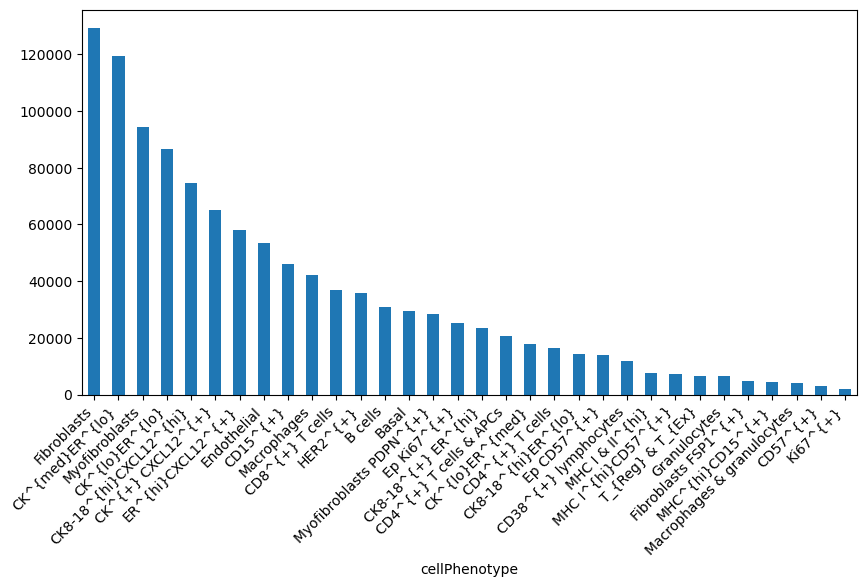

In [17]:
total_count_types = count_types.sum().sort_values(ascending=False)
ax = total_count_types.plot.bar(figsize=(10, 5))
plt.xticks(rotation=45, ha='right');
# plt.savefig(save_dir / 'cell_types_proportions.jpg', bbox_inches='tight', facecolor='white', dpi=600)

In [18]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

cellPhenotype,B cells,Basal,CD15^{+},CD38^{+} lymphocytes,CD4^{+} T cells,CD4^{+} T cells & APCs,CD57^{+},CD8^{+} T cells,CK8-18^{+} ER^{hi},CK8-18^{hi}CXCL12^{hi},...,HER2^{+},Ki67^{+},MHC I & II^{hi},MHC I^{hi}CD57^{+},MHC^{hi}CD15^{+},Macrophages,Macrophages & granulocytes,Myofibroblasts,Myofibroblasts PDPN^{+},T_{Reg} & T_{Ex}
metabric_id,,,,,,,,,,,,,,,,,,,,,
MB-0000,0.003968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,0.003968,0.039683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.000000,0.015873,0.000000,0.000000
MB-0002,0.000000,0.000000,0.000473,0.000000,0.000946,0.000000,0.000000,0.003310,0.000000,0.421749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003783,0.000000,0.135697,0.002364,0.000000
MB-0005,0.000641,0.000000,0.452854,0.000000,0.000000,0.000000,0.000000,0.007056,0.000641,0.012187,...,0.001924,0.000000,0.000000,0.000000,0.000000,0.005131,0.001924,0.295061,0.003849,0.000000
MB-0006,0.001235,0.020988,0.000000,0.006173,0.004938,0.000000,0.000000,0.004938,0.000000,0.116049,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008642,0.000000,0.106173,0.000000,0.000000
MB-0010,0.000716,0.000000,0.001433,0.004298,0.009312,0.003582,0.000000,0.005731,0.729226,0.000000,...,0.000000,0.002149,0.005014,0.000716,0.000000,0.035817,0.000000,0.045129,0.032235,0.000716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-3824,0.005736,0.001912,0.038241,0.005736,0.009560,0.000000,0.000000,0.001912,0.000000,0.005736,...,0.001912,0.000000,0.000000,0.000000,0.000000,0.053537,0.000000,0.202677,0.011472,0.000000
MB-3838,0.000000,0.000000,0.275424,0.000000,0.002119,0.000000,0.004237,0.019068,0.000000,0.029661,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002119,0.000000,0.144068,0.010593,0.002119
MB-3854,0.000000,0.002342,0.199063,0.000000,0.025761,0.000000,0.000000,0.035129,0.002342,0.016393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.014052,0.000000,0.093677,0.014052,0.000000


In [19]:
surv_orig = surv.copy()
surv = surv.loc[~surv['isValidation'], :]
surv.drop(columns=['isValidation'], inplace=True)

In [20]:
surv

,ERStatus,LymphNodesOrdinal,sizeOrdinal,Grade,ERBB2_pos,yearsToStatus,DeathBreast,PAM50,IntClust
metabric_id,,,,,,,,,
MB-0000,pos,7+,20-50mm,3.0,False,11.540041,0,Normal-like,IntClust 4+
MB-0002,pos,0,5-10mm,3.0,False,6.951403,0,Luminal A,IntClust 4+
MB-0005,pos,1,10-20mm,2.0,False,13.445585,1,Luminal B,IntClust 3
MB-0006,pos,2-3,20-50mm,2.0,False,13.546886,0,Luminal B,IntClust 9
MB-0010,pos,0,20-50mm,3.0,False,0.640657,1,Luminal B,IntClust 7
...,...,...,...,...,...,...,...,...,...
MB-3688,pos,0,20-50mm,3.0,NaN,2.179329,1,NaN,NaN
MB-3692,pos,1,20-50mm,3.0,NaN,5.089665,1,NaN,NaN
MB-3747,pos,0,20-50mm,2.0,NaN,18.877481,0,NaN,NaN


In [21]:
# replace some values with numbers for fitting
mapper_str = {
    'pos': 1,
    'neg': 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERStatus'] = surv['ERStatus'].map(mapper_str)

mapper_bool = {
    True: 1,
    False: 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERBB2_pos'] = surv['ERBB2_pos'].map(mapper_bool)

In [22]:
duration_col = 'yearsToStatus'
event_col = 'DeathBreast'
covariates = ['ERStatus'] #, 'ERBB2_pos'] # else []
strata = 'ERStatus'
drop_last_column = True   # because we use proportions last column is fully determined
drop_nan = True
if drop_last_column:
    df_surv = prop_types.iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = prop_types.join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 509 observations with NaN


In [23]:
df_surv

,B cells,Basal,CD15^{+},CD38^{+} lymphocytes,CD4^{+} T cells,CD4^{+} T cells & APCs,CD57^{+},CD8^{+} T cells,CK8-18^{+} ER^{hi},CK8-18^{hi}CXCL12^{hi},...,MHC I & II^{hi},MHC I^{hi}CD57^{+},MHC^{hi}CD15^{+},Macrophages,Macrophages & granulocytes,Myofibroblasts,Myofibroblasts PDPN^{+},yearsToStatus,DeathBreast,ERStatus
metabric_id,,,,,,,,,,,,,,,,,,,,,
MB-0000,0.003968,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.015873,0.003968,0.039683,...,0.000000,0.000000,0.000000,0.011905,0.000000,0.015873,0.000000,11.540041,0,1.0
MB-0002,0.000000,0.000000,0.000473,0.000000,0.000946,0.000000,0.0,0.003310,0.000000,0.421749,...,0.000000,0.000000,0.000000,0.003783,0.000000,0.135697,0.002364,6.951403,0,1.0
MB-0005,0.000641,0.000000,0.452854,0.000000,0.000000,0.000000,0.0,0.007056,0.000641,0.012187,...,0.000000,0.000000,0.000000,0.005131,0.001924,0.295061,0.003849,13.445585,1,1.0
MB-0006,0.001235,0.020988,0.000000,0.006173,0.004938,0.000000,0.0,0.004938,0.000000,0.116049,...,0.000000,0.000000,0.000000,0.008642,0.000000,0.106173,0.000000,13.546886,0,1.0
MB-0010,0.000716,0.000000,0.001433,0.004298,0.009312,0.003582,0.0,0.005731,0.729226,0.000000,...,0.005014,0.000716,0.000000,0.035817,0.000000,0.045129,0.032235,0.640657,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-3688,0.000429,0.002575,0.000858,0.000000,0.014163,0.008155,0.0,0.014592,0.000000,0.000000,...,0.001717,0.000000,0.000000,0.020601,0.000000,0.297425,0.057511,2.179329,1,1.0
MB-3692,0.019431,0.000000,0.006161,0.155450,0.009953,0.099052,0.0,0.059242,0.000000,0.027488,...,0.011848,0.000948,0.000948,0.024645,0.017062,0.045972,0.067773,5.089665,1,1.0
MB-3747,0.000000,0.000000,0.000000,0.000000,0.000808,0.000000,0.0,0.012126,0.000000,0.383994,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.172191,0.000808,18.877481,0,1.0


In [24]:
cph = CoxPHFitter(penalizer=0.0001)
if strata is None:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

/home/alexis/miniconda3/envs/mosna-gpu/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Fibroblasts FSP1^{+}', 'Ki67^{+}'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


model,lifelines.CoxPHFitter
duration col,'yearsToStatus'
event col,'DeathBreast'
penalizer,0.0001
l1 ratio,0.0
strata,ERStatus
baseline estimation,breslow
number of observations,494
number of events observed,155
partial log-likelihood,-756.55
time fit was run,2024-04-19 11:09:26 UTC


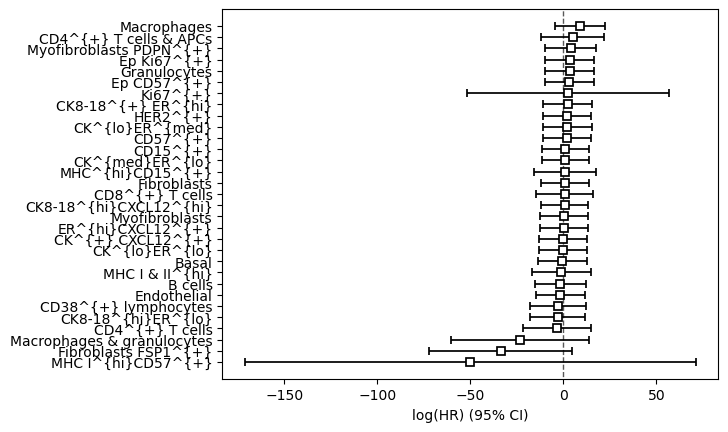

In [25]:
cph.plot();

In [26]:
def surv_col_to_numpy(df_surv, event_col, duration_col):
    y_df = df_surv[[event_col, duration_col]].copy()
    y_df.loc[:, event_col] = y_df.loc[:, event_col].astype(bool)
    records = y_df.to_records(index=False)
    y = np.array(records, dtype = records.dtype.descr)
    return y

In [31]:
plot_alphas = True
plot_best_model_coefs = True
recompute = False

DEBUG = True
if DEBUG:
    verbose = 2
else:
    verbose = 0
show_progress = False

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
min_alpha = 0.001
# dir_save_interm = sof_dir / 'search_CoxPH'
# dir_save_interm.mkdir(parents=True, exist_ok=True)

l1_ratio: 0.1
l1_ratio: 0.5
l1_ratio: 0.7
l1_ratio: 0.9
l1_ratio: 0.95
l1_ratio: 0.99
l1_ratio: 1


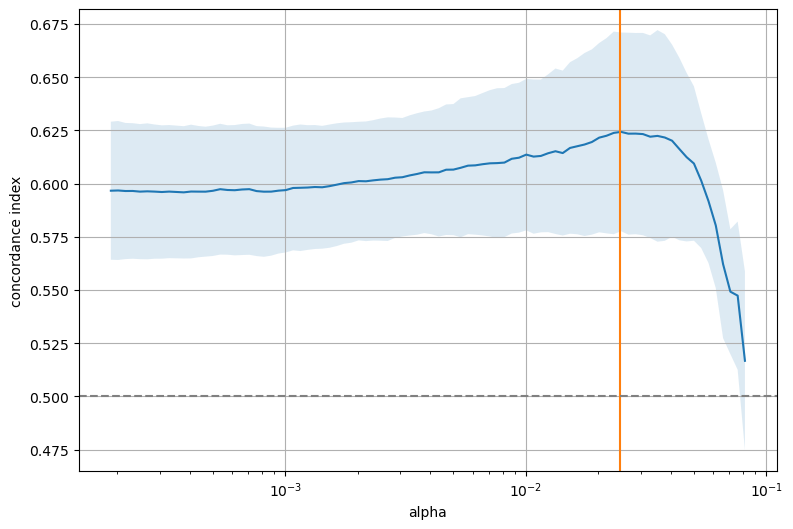

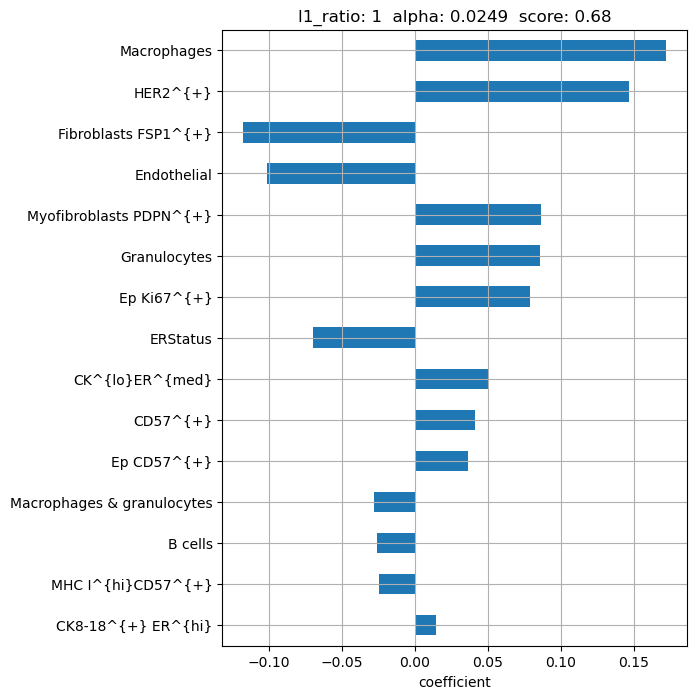

In [32]:

# normalize = 'niche'

# var_aggreg_niches = var_aggreg_samples_info.copy()
# var_aggreg_niches['niche'] = np.array(niches)
# counts = mosna.make_niches_composition(var_aggreg_niches['patient'], niches, var_label=patient_col, normalize=normalize)

# duration_col = 'yearsToStatus'
# event_col = 'DeathBreast'
# covariates = [] # ['ERStatus'] #, 'ERBB2_pos'] # else []
# strata = None #'ERStatus'
# status = surv[[duration_col, event_col] + covariates]

# drop_nan = True
# df_surv = counts.merge(status, how='inner', on=patient_col)
# if drop_nan:
#     n_obs_orig = len(df_surv)
#     df_surv.dropna(axis=0, inplace=True)
#     n_obs = len(df_surv)


non_pred_cols = [patient_col, sample_col, event_col, duration_col]
pred_cols = [x for x in df_surv if x not in non_pred_cols]
# Xt = OneHotEncoder().fit_transform(X)
Xt = df_surv[pred_cols]
Xt.columns = Xt.columns.astype(str)
y = surv_col_to_numpy(df_surv, event_col, duration_col)

# Search best CoxPH model
models = []
scores = []
all_cv_results = []
for l1_ratio in l1_ratios:
    print(f'l1_ratio: {l1_ratio}')

    coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=min_alpha, max_iter=100))
    coxnet_pipe.fit(Xt, y)

    # retrieve best alpha
    estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
    # estimated_alphas = [0.1, 0.01]

    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=l1_ratio)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
    ).fit(Xt, y)

    cv_results = pd.DataFrame(gcv.cv_results_)

    # retrieve best model
    best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

    models.append(best_model)
    scores.append(best_model.score(Xt, y))
    all_cv_results.append(cv_results)

best_score_id = np.argmax(scores)
best_model = models[best_score_id]
best_cv = all_cv_results[best_score_id]
score = scores[best_score_id]
l1_ratio = best_model.l1_ratio
alpha = best_model.alphas[0]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])
non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
# print(f"Number of non-zero coefficients: {non_zero}")
non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index
n_coefs = len(non_zero_coefs)

if plot_alphas:
    alphas = best_cv.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = best_cv.mean_test_score
    std = best_cv.std_test_score

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

if plot_best_model_coefs:
    _, ax = plt.subplots(figsize=(6, 8))
    non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
    ax.set_xlabel("coefficient")
    ax.set_title(f'l1_ratio: {l1_ratio}  alpha: {alpha:.3g}  score: {score:.3g}')
    ax.grid(True)

In [54]:
strata = None

cph = CoxPHFitter(penalizer=alpha, l1_ratio=l1_ratio)
if strata is None:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

/home/alexis/miniconda3/envs/mosna-gpu/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Fibroblasts FSP1^{+}', 'Ki67^{+}'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 494 total observations, 339 right-censored observations>
             duration col = 'yearsToStatus'
                event col = 'DeathBreast'
                penalizer = 0.024864422234087424
                 l1 ratio = 0.99
      baseline estimation = breslow
   number of observations = 494
number of events observed = 155
   partial log-likelihood = -870.72
         time fit was run = 2024-04-19 11:32:32 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
B cells                     -0.40       0.67       1.27            -2.90             2.10                 0.06                 8.15
Basal                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD15^{+}                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD38^{+} lymphocytes        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
CD4^{+} T cells             -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
CD4^{+} T cells & APCs       0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
CD57^{+}                     0.97       2.65       1.73            -2.41             4.36                 0.09                78.32
CD8^{+} T cells             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CK8-18^{+} ER^{hi}           0.17       1.19       1.15            -2.09             2.44                 0.12                11.44
CK8-18^{hi}CXCL12^{hi}      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CK8-18^{hi}ER^{lo}          -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
CK^{+} CXCL12^{+}           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CK^{lo}ER^{lo}              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CK^{lo}ER^{med}              0.95       2.58       1.61            -2.21             4.11                 0.11                60.70
CK^{med}ER^{lo}              0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ER^{hi}CXCL12^{+}           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Endothelial                 -1.39       0.25       1.45            -4.24             1.46                 0.01                 4.30
Ep CD57^{+}                  0.58       1.78       1.51            -2.38             3.54                 0.09                34.31
Ep Ki67^{+}                  1.61       5.02       1.46            -1.24             4.47                 0.29                87.43
Fibroblasts                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Fibroblasts FSP1^{+}       -18.65       0.00      15.47           -48.98            11.68                 0.00             1.19e+05
Granulocytes                 2.75      15.65       2.18            -1.51             7.01                 0.22              1112.02
HER2^{+}                     1.27       3.55       0.62             0.06             2.48                 1.06                11.88
Ki67^{+}                     0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
MHC I & II^{hi}             -0.00       1.00       0.01            -0.01             0.01                 0.99    

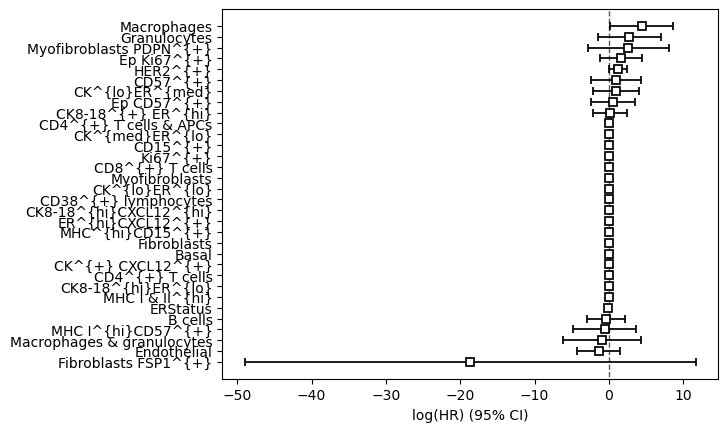

In [55]:
cph.plot();

In [60]:
# Get significant coefficients only
coefs_sig = mosna.get_significant_coefficients(cph.confidence_intervals_)
n_sig_coefs = len(coefs_sig)
print(f'There are {n_sig_coefs} significant coefficients in the CoxPH model:')
for c in coefs_sig:
    print(f'    {c}')

There are 2 significant coefficients in the CoxPH model:
    HER2^{+}
    Macrophages


In [135]:
    cols_cmap = mosna.make_cluster_cmap(columns)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(cols_cmap)
    colors = [cols_cmap[i % n_colors] for i in range(len(columns))]

32

In [138]:
len(columns)

32

In [82]:
def renormalize(data, mini, maxi):
    data = data - np.min(data)
    data = data / np.max(data)
    data = data * (maxi - mini)
    data = data + mini
    return data

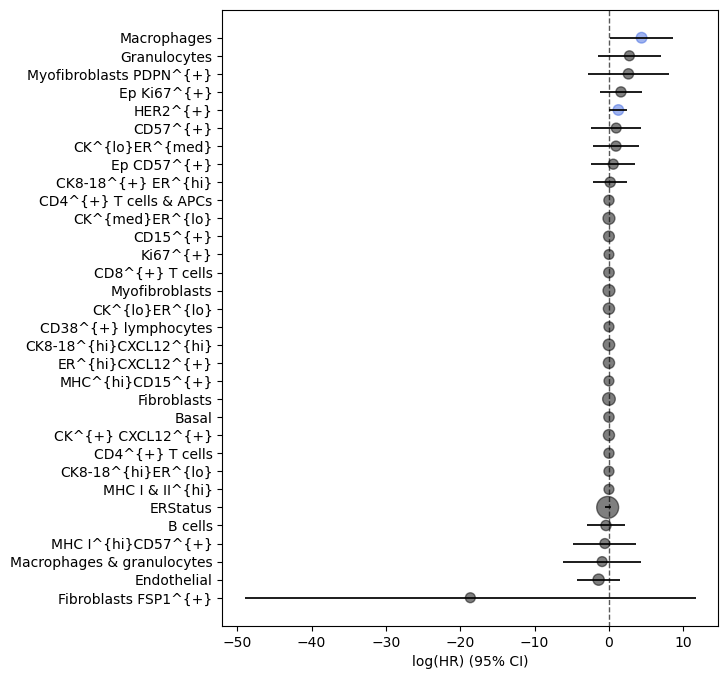

In [152]:

model=cph
data=df_surv
columns=None
hazard_ratios=False
colors=None
ax=None
errorbar_kwargs={}
min_size = 1
max_size = 5
y_spacing = 1
auto_colors = False
grey_non_significant = True
default_color = 'royalblue'
y_ticks_coeff = 0.25

from matplotlib import pyplot as plt

if ax is None:
    ax = plt.gca()

errorbar_kwargs.setdefault("c", "k")
errorbar_kwargs.setdefault("fmt", "o")
errorbar_kwargs.setdefault("markerfacecolor", "white")
errorbar_kwargs.setdefault("markeredgewidth", 1.25)
errorbar_kwargs.setdefault("elinewidth", 1.25)
errorbar_kwargs.setdefault("capsize", None)

from lifelines.utils import inv_normal_cdf
z = inv_normal_cdf(1 - model.alpha / 2)
user_supplied_columns = True

if columns is None:
    user_supplied_columns = False
    columns = model.params_.index

yaxis_locations = np.arange(len(columns))
log_hazards = model.params_.loc[columns].values.copy()

order = list(range(len(columns) - 1, -1, -1)) if user_supplied_columns else np.argsort(log_hazards)

if colors is None:
    if auto_colors:
        cols_cmap = mosna.make_cluster_cmap(columns)
        # make color mapper
        # series to sort by decreasing order
        n_colors = len(cols_cmap)
        colors = [cols_cmap[i % n_colors] for i in range(len(columns))]
    else:
        colors = [default_color] * len(order)
if grey_non_significant:
    coefs_sig = mosna.get_significant_coefficients(cph.confidence_intervals_)
    # model[pval_col][i]<= 0.05
    colors = [x if columns[i] in coefs_sig else 'k' for i, x in enumerate(colors)]
colors = np.array(colors)[order]
if data is not None:
    weights = data.loc[:, columns].sum(axis=0)
    sizes = renormalize(np.array(weights), min_size, max_size)[order] * 50
    errorbar_kwargs['fmt'] = 'none'
else:
    sizes = np.ones(len(columns)) * min_size * 50
# errorbar_kwargs["s"] = sizes

if hazard_ratios:
    exp_log_hazards = np.exp(log_hazards)
    upper_errors = exp_log_hazards * (np.exp(z * model.standard_errors_[columns].values) - 1)
    lower_errors = exp_log_hazards * (1 - np.exp(-z * model.standard_errors_[columns].values))
    ax.scatter(
        exp_log_hazards[order],
        yaxis_locations,
        c=colors, 
        s=sizes, 
        alpha=0.5,
        # cmap='viridis',
        )
    ax.errorbar(
        exp_log_hazards[order],
        yaxis_locations,
        xerr=np.vstack([lower_errors[order], upper_errors[order]]),
        **errorbar_kwargs,
    )
    ax.set_xlabel("HR (%g%% CI)" % ((1 - model.alpha) * 100))
else:
    symmetric_errors = z * model.standard_errors_[columns].values
    ax.scatter(
        log_hazards[order],
        yaxis_locations,
        c=colors, 
        s=sizes, 
        alpha=0.5,
        # cmap='viridis',
        )
    ax.errorbar(
        log_hazards[order], 
        yaxis_locations, 
        xerr=symmetric_errors[order], 
        **errorbar_kwargs)
    ax.set_xlabel("log(HR) (%g%% CI)" % ((1 - model.alpha) * 100))

best_ylim = ax.get_ylim()
ax.vlines(1 if hazard_ratios else 0, -2, len(columns) + 1, linestyles="dashed", linewidths=1, alpha=0.65, color="k")
ax.set_ylim(best_ylim)

tick_labels = [columns[i] for i in order]

ax.set_yticks(yaxis_locations);
ax.set_yticklabels(tick_labels);
fig = ax.get_figure()
fig.set_size_inches([6.4, y_ticks_coeff * len(columns)])



In [157]:
def plot_survival_coeffs(
    model, 
    data=None, 
    columns=None, 
    hazard_ratios=False, 
    colors=None, 
    min_size=1,
    max_size=5,
    auto_colors=False,
    grey_non_significant=True,
    default_color='royalblue',
    y_ticks_coeff=0.25,
    ax=None, 
    **errorbar_kwargs,
    ):
    """
    Produces a visual representation of the coefficients (i.e. log hazard ratios), including their standard errors and magnitudes.

    Parameters
    ----------
    columns : list, optional
        specify a subset of the columns to plot
    hazard_ratios: bool, optional
        by default, ``plot`` will present the log-hazard ratios (the coefficients). However, by turning this flag to True, the hazard ratios are presented instead.
    errorbar_kwargs:
        pass in additional plotting commands to matplotlib errorbar command

    Examples
    ---------
    >>> cph = CoxPHFitter(penalizer=alpha, l1_ratio=l1_ratio)
    >>> cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)
    >>> ax = plot_survival_coeffs(cph, data=df_surv)

    Returns
    -------
    ax: matplotlib axis
        the matplotlib axis that be edited.

    """
    from matplotlib import pyplot as plt

    if ax is None:
        ax = plt.gca()

    errorbar_kwargs.setdefault("c", "k")
    errorbar_kwargs.setdefault("fmt", "o")
    errorbar_kwargs.setdefault("markerfacecolor", "white")
    errorbar_kwargs.setdefault("markeredgewidth", 1.25)
    errorbar_kwargs.setdefault("elinewidth", 1.25)
    errorbar_kwargs.setdefault("capsize", None)

    from lifelines.utils import inv_normal_cdf
    z = inv_normal_cdf(1 - model.alpha / 2)
    user_supplied_columns = True

    if columns is None:
        user_supplied_columns = False
        columns = model.params_.index

    yaxis_locations = np.arange(len(columns))
    log_hazards = model.params_.loc[columns].values.copy()

    order = list(range(len(columns) - 1, -1, -1)) if user_supplied_columns else np.argsort(log_hazards)

    if colors is None:
        if auto_colors:
            cols_cmap = mosna.make_cluster_cmap(columns)
            # make color mapper
            # series to sort by decreasing order
            n_colors = len(cols_cmap)
            colors = [cols_cmap[i % n_colors] for i in range(len(columns))]
        else:
            colors = [default_color] * len(order)
    if grey_non_significant:
        coefs_sig = mosna.get_significant_coefficients(cph.confidence_intervals_)
        # model[pval_col][i]<= 0.05
        colors = [x if columns[i] in coefs_sig else 'k' for i, x in enumerate(colors)]
    colors = np.array(colors)[order]
    if data is not None:
        weights = data.loc[:, columns].sum(axis=0)
        sizes = renormalize(np.array(weights), min_size, max_size)[order] * 50
        errorbar_kwargs['fmt'] = 'none'
    else:
        sizes = np.ones(len(columns)) * min_size * 50
    # errorbar_kwargs["s"] = sizes

    if hazard_ratios:
        exp_log_hazards = np.exp(log_hazards)
        upper_errors = exp_log_hazards * (np.exp(z * model.standard_errors_[columns].values) - 1)
        lower_errors = exp_log_hazards * (1 - np.exp(-z * model.standard_errors_[columns].values))
        ax.scatter(
            exp_log_hazards[order],
            yaxis_locations,
            c=colors, 
            s=sizes, 
            alpha=0.5,
            # cmap='viridis',
            )
        ax.errorbar(
            exp_log_hazards[order],
            yaxis_locations,
            xerr=np.vstack([lower_errors[order], upper_errors[order]]),
            **errorbar_kwargs,
        )
        ax.set_xlabel("HR (%g%% CI)" % ((1 - model.alpha) * 100))
    else:
        symmetric_errors = z * model.standard_errors_[columns].values
        ax.scatter(
            log_hazards[order],
            yaxis_locations,
            c=colors, 
            s=sizes, 
            alpha=0.5,
            # cmap='viridis',
            )
        ax.errorbar(
            log_hazards[order], 
            yaxis_locations, 
            xerr=symmetric_errors[order], 
            **errorbar_kwargs)
        ax.set_xlabel("log(HR) (%g%% CI)" % ((1 - model.alpha) * 100))

    best_ylim = ax.get_ylim()
    ax.vlines(1 if hazard_ratios else 0, -2, len(columns) + 1, linestyles="dashed", linewidths=1, alpha=0.65, color="k")
    ax.set_ylim(best_ylim)

    tick_labels = [columns[i] for i in order]

    ax.set_yticks(yaxis_locations);
    ax.set_yticklabels(tick_labels);
    fig = ax.get_figure()
    fig.set_size_inches([6.4, y_ticks_coeff * len(columns)])

    return ax

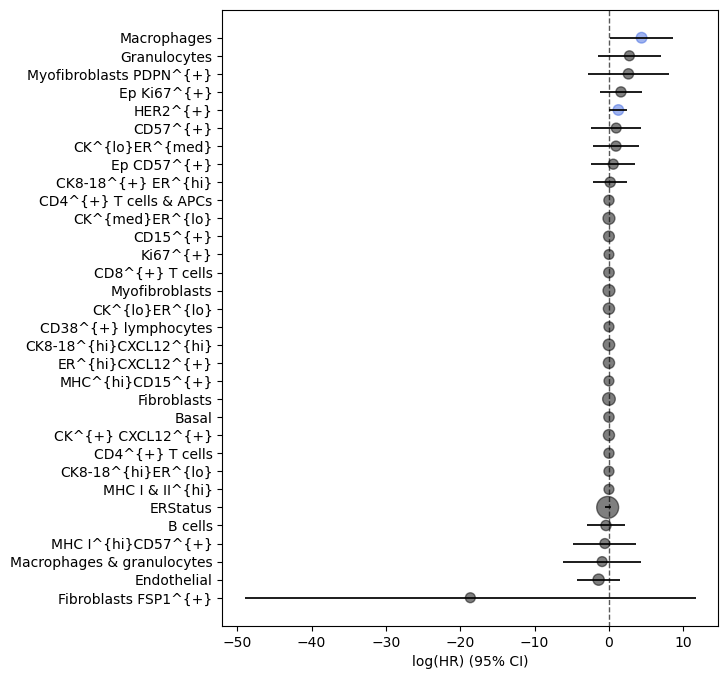

In [158]:
ax = plot_coeffs(cph, data=df_surv)